In [ ]:
# ---------------------------------------------------------------
# 📘 Capstone: Fake News Detection with Advanced Features & Models
# ---------------------------------------------------------------

# ✅ 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Optional: Display all columns
pd.set_option("display.max_columns", None)



In [5]:
# ✅ 2. Load Data
df = pd.read_csv(r"C:\Users\Mr. Louis\Downloads\fake.csv")
print("Shape:", df.shape)
df.head()


Shape: (12999, 20)


,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\Mr.
[nltk_data]     Louis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Mr.
[nltk_data]     Louis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# ✅ 3. Data Cleaning and Preprocessing
# Check missing values
print(df.isnull().sum())

# Drop columns if not needed
columns_to_drop = ['uuid', 'main_img_url']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Fill missing text
df['text'] = df['text'].fillna("")

# Clean text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

# Basic text stats
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_text'].apply(len)

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64


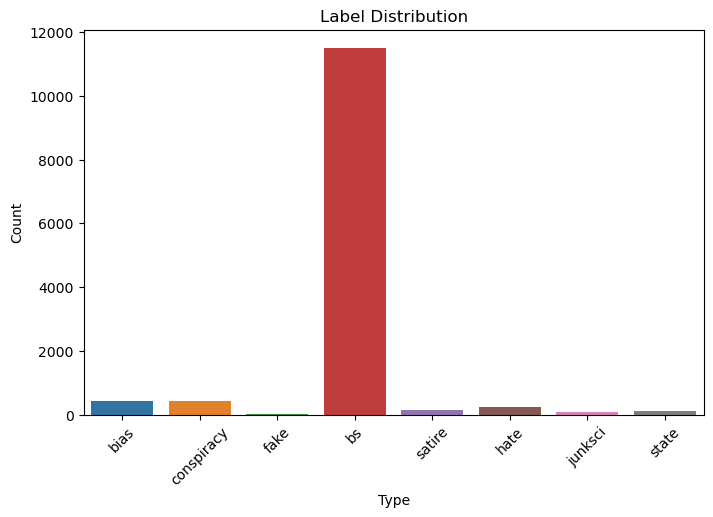

Label counts:
 bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64


In [8]:
# ✅ 4. Basic Statistics and Label Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='type', data=df)
plt.title('Label Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print("Label counts:\n", df['type'].value_counts())

In [9]:
# ---------------------------------------------------------------
# ✅ 5. Advanced Feature Engineering
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['clean_text'])
print("TF-IDF shape:", X_tfidf.shape)

# Sentiment polarity
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Domain extraction
df['domain'] = df['site_url'].apply(lambda x: x.split('//')[-1].split('/')[0])
domain_encoder = LabelEncoder()
df['domain_encoded'] = domain_encoder.fit_transform(df['domain'])


TF-IDF shape: (12999, 5000)


NameError: name 'TextBlob' is not defined

In [11]:
# ✅ 6. Preparing Data for Modeling
# Combine TF-IDF with sentiment and domain
from scipy.sparse import hstack

# Reshape numeric features to sparse format
sentiment_sparse = np.array(df['sentiment']).reshape(-1,1)
domain_sparse = np.array(df['domain_encoded']).reshape(-1,1)

X_final = hstack([X_tfidf, sentiment_sparse, domain_sparse])

# Target labels
y = df['type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)



KeyError: 'sentiment'

In [10]:
# ✅ 7. Model 1 - Logistic Regression
clf_lr = LogisticRegression(max_iter=200)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

NameError: name 'LogisticRegression' is not defined

In [12]:
# ---------------------------------------------------------------
# ✅ 8. Model 2 - Random Forest
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

print("\nRandom Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



NameError: name 'RandomForestClassifier' is not defined

In [13]:
# ---------------------------------------------------------------
# ✅ 9. Model 3 - XGBoost
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

print("\nXGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))



NameError: name 'XGBClassifier' is not defined

In [14]:
# ---------------------------------------------------------------
# ✅ 10. Feature Importance (Logistic Regression Coefficients)
feature_names = tfidf.get_feature_names_out()
coefs = clf_lr.coef_[0]

top_positive = sorted(zip(coefs, feature_names), reverse=True)[:10]
top_negative = sorted(zip(coefs, feature_names))[:10]

print("\nTop Positive Features:", top_positive)
print("Top Negative Features:", top_negative)


NameError: name 'clf_lr' is not defined